<a href="https://colab.research.google.com/github/dwtkse33/ml_GoogleColab/blob/master/%EB%8F%99%ED%83%84%2C_%EB%B3%91%EC%A0%90%EB%8F%99_%EB%B2%84%EC%8A%A4%EB%85%B8%EC%84%A0_%EB%B6%84%EC%84%9D_%EC%83%81%EC%A4%80%EB%8B%98_%ED%8C%8C%EC%9D%BC_%EC%B0%B8%EA%B3%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 동탄/병점동 중심의 버스노선 분석

### 분석에 필요한 library import 및 파일 준비

In [ ]:
import os

# for data aggregation.
import numpy as np
import pandas as pd
import geopandas as gpd
from geopy.distance import distance, lonlat

from tqdm import tqdm_notebook

# for data visualisation.
import matplotlib.pyplot as plt
import plotly_express as px
##plotly : matplotlib, seaborn 만 사용하다가, 최근에 훨씬 세련된 데이터 시각화 툴을 찾았습니다.
##plotly 인데, 웹 시각화 라이브러리인 d3.js 를 이용하여 보다 interactive 하게 그래프를 만들어줍니다.

출처: https://dailyheumsi.tistory.com/118 [하나씩 점을 찍어 나가며]
import chart_studio.plotly as py
import cufflinks as cf 
cf.go_offline(connected=True)
cf.set_config_file(theme='polar')
import deckgljupyter.Layer as deckgl
##Deckgl-jupyter 는 위치 데이터 시각화 라이브러리인 Deck.gl 을 쥬피터 
# 노트북 에서도 쓸 수 있게 만든 라이브러리 입니다.
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from matplotlib import rc
#rc는 configuration의 약자로, matplotlib의 원래 default를 수정해주는 명령
import matplotlib
import matplotlib.font_manager
plt.rcParams["font.family"] = 'NanumBarunGothic'
#[(f.name, f.fname) for f in matplotlib.font_manager.fontManager.ttflist if 'Nanum' in f.name]

# rc('font', family='AppleGothic')
# plt.rcParams['axes.unicode_minus'] = False

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings
warnings.filterwarnings('ignore')


In [ ]:
%cd hs_data/

/Users/dummy/Codes/hs_data


In [ ]:
df_stations = pd.read_csv('PJT001_stations_table.csv')
df_station_mapping = pd.read_csv('PJT001_routestationmapping.csv')
df_route_station = pd.read_csv('PJT001_routestationinfo.csv')

----

## 1) 동탄/병점 지역 버스노선 <font color='red'>중복도</font>에 대한 조사

**통탄/병점동 버스노선에 대해 조사를 위해 해당 지역에 위치한 정류장만을 선택합니다.**

In [ ]:
#1. station_table에서 화성시만 검색
df_station_hs = df_stations.loc[df_stations['시군명'].str.contains('화성시', na=False)]


#2. 정류소의 위치에 '병점|동탄|반월|진안|화산|기배' 포함된 정류소만 검색
df_station_hs = df_station_hs.loc[df_station_hs['위치'].str.contains('병점|동탄|반월|진안|화산|기배', na=False)]


#3. 경유지 정류장ID인 27로 시작하는 ID값을 제외한 표준정류장ID를 검색, 
# match함수는 문자열에만 사용가능하기 때문에 str으로 변환 (아래에는 int로 재변환)
df_station_hs['표준정류장ID'] = df_station_hs['표준정류장ID'].astype(np.str) 
#np is numpy
df_station_hs = df_station_hs[~df_station_hs['표준정류장ID'].str.match('27')]     
df_station_hs.shape

(202, 12)

**버스 정류장에 대한 정보 테이블과 버스노선-정류장 매핑 테이블을 merge 합니다.**

In [ ]:
# merge을 위해 dtype을 int로 다시 변환
df_station_hs['표준정류장ID'] = df_station_hs['표준정류장ID'].astype(np.int)

# 정류장ID별로 merge
#outer join, inner join, left, right 등 SQL에서도 다루는데 이 부분 복습필요!!
df_station_merge = pd.merge(df_route_station, 
             df_station_hs[['표준정류장ID', '정류소명', 'WGS84위도', 'WGS84경도', '관할관청', '위치']],
             left_on='station_id', right_on='표준정류장ID', how='inner')

# route id나 station id가 없는 data drop
#inplace = True 명령 준 것을 반영 
df_station_merge.dropna(subset=['pr_station_id', 'station_id'], inplace=True)
df_station_merge.shape

(1079, 13)

In [ ]:
# ID값의 dtype을 float -> int 로 변경
df_station_merge = df_station_merge.astype({"pr_station_id": int, "bus_line_no_seq": int, "station_id": int})

In [ ]:
# 편의상 column의 순서를 다시 조합 및 rename
df_station_smy = df_station_merge[['pr_station_id', 'bus_line_no', 'bus_line_no_seq', 'station_id', 'station_nm', 'WGS84위도', 'WGS84경도' ,'관할관청' , '위치']]
df_station_smy.shape

new_col_names = ['ROUTE_ID', 'ROUTE_NM', 'SEQ', 'STATION_ID', 'STATION_NM', 'MAP_LAT', 'MAP_LON' ,'관할관청', '위치']
df_station_smy.columns = new_col_names

# 노선ID, 정류장순서 순으로 정렬
df_station_smy.sort_values(by=["ROUTE_ID", "SEQ"])

,ROUTE_ID,ROUTE_NM,SEQ,STATION_ID,STATION_NM,MAP_LAT,MAP_LON,관할관청,위치
0,228000204,24,53,233000169,한원IC,37.152733,127.122883,경기도 화성시,경기도 화성시 동탄면
1,228000204,24,54,233000168,장지동,37.155117,127.117900,경기도 화성시,경기도 화성시 동탄면
4,228000204,24,55,233000167,장지동,37.155867,127.115017,경기도 화성시,경기도 화성시 동탄면
7,228000204,24,58,233000166,꽃가마약수터,37.159100,127.099350,경기도 화성시,경기도 화성시 동탄면
8,228000204,24,80,233001323,꽃가마약수터,37.158900,127.098750,경기도 화성시,경기도 화성시 동탄면
...,...,...,...,...,...,...,...,...,...
1047,241491011,38-1,42,233002394,안화고등학교,37.211433,127.047517,경기도 화성시,경기도 화성시 병점동
754,241491011,38-1,43,233000071,안화초교.주공8.9단지,37.213300,127.046083,경기도 화성시,경기도 화성시 병점동
849,241491011,38-1,44,233000066,중심상가,37.215150,127.043750,경기도 화성시,경기도 화성시 진안동
763,241491011,38-1,45,233002132,롯데시네마,37.214483,127.042450,경기도 화성시,경기도 화성시 진안동


**COMPAS 가이드를 참고하여 동탄/병점주변 버스 노선 중복도 dataframe 생성**

In [ ]:
# ods[route_id] 에 route_id 노선의 전 구간을 set 에 담습니다.
ods = {}
grp = df_station_smy.groupby('ROUTE_ID')

for route_id, gdf in grp:
    gdf = gdf.sort_values('SEQ')
    od_set = set()
    for i in range(1, len(gdf)):
        od = (gdf['STATION_ID'].iloc[i-1], gdf['STATION_ID'].iloc[i])
        od_set.add(od)
    ods[route_id] = od_set

    
# diff_routes[route_id1][route_id2] 에 노선 route_id1와 route_id2 간의 중복도 값을 구합니다.
##Q: 이부분 이해 필요 ! 
diff_routes = {}
for route_id1, od_set1 in ods.items():
    d = {}
    for route_id2, od_set2 in ods.items():
        diff = od_set1 & od_set2
        try:
            d[route_id2] = len(diff) / len(od_set1)
        except:
            print(ods.items())
    diff_routes[route_id1] = d

In [ ]:
# 위에서 구한 두 노선의 중복도 값을 데이터프레임으로 만들어줍니다.
# 0~1의 값을 0~100(%) 로 바꿔줍니다.
df_redundancy = pd.DataFrame(diff_routes)
df_redundancy = df_redundancy * 100
df_redundancy.shape

(61, 61)

**위에서 생성한 dataframe을 히트맵으로 시각화 해보겠습니다.**

x, y 축은 각각 노선의 아이디 입니다.

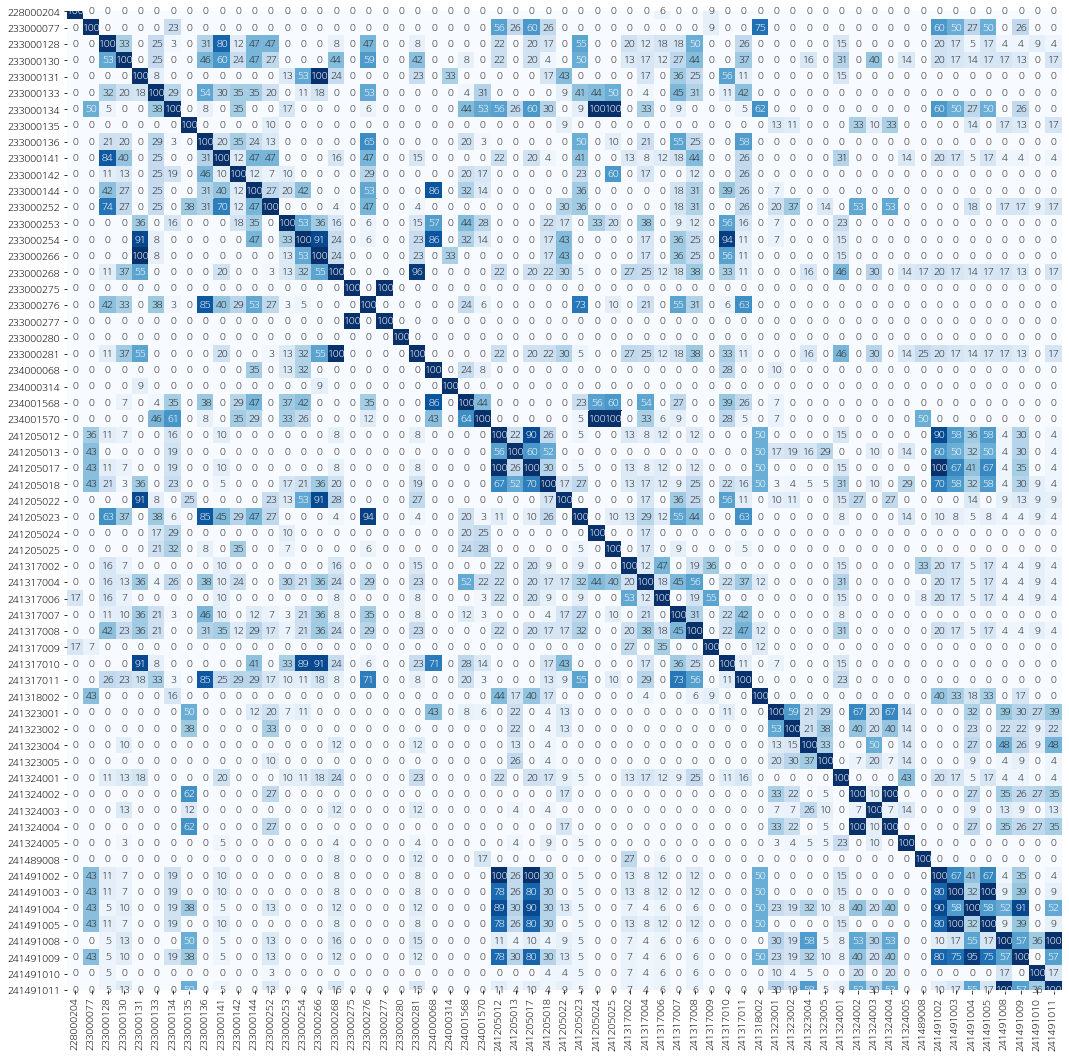

In [ ]:
plt.figure(figsize=(18, 18))
sns.heatmap(df_redundancy, square=True, annot=True, fmt='.0f', cmap='Blues', cbar=False, vmin=0, vmax=100)
plt.show()

**조금 더 자세한 수치를 알기위해 중복값의 분포도를 보도록하겠습니다.**

In [ ]:
redundancy_flat = df_redundancy.values.flatten()
redundancy_flat = [i for i in redundancy_flat if i != 100]

In [ ]:
pd.Series(redundancy_flat).describe()

count    3641.000000
mean        8.216047
std        16.088612
min         0.000000
25%         0.000000
50%         0.000000
75%        10.000000
max        96.153846
dtype: float64

**0의 값이 많지만, 최대 96% 중복되는 노선 쌍도 있는것을 확인했습니다.**

높은 중복도를 가지고 있는 노선의 개수를 알아보기위해 **90%** 이상의 중복도만 뽑도록 하겠습니다.

In [ ]:
topn_pair = {}
for route_id1, others in diff_routes.items():
    for route_id2, redundancy in others.items():
        if route_id1 == route_id2:
            continue
        if redundancy >= 0.9 and (topn_pair.get((route_id2, route_id1), None) == None):
            topn_pair[(route_id1, route_id2)] = redundancy

In [ ]:
len(topn_pair)

24

총 24개의 노선쌍이 추출됐습니다.

이제 이 노선쌍들을 시각화 하여 살펴보겠습니다.

In [ ]:
df_topn_pair = pd.Series(topn_pair).to_frame().reset_index()
df_topn_pair.columns = ['route_1', 'route_2', 'redundancy']
df_topn_pair.sort_values('redundancy', ascending=False, inplace=True)
df_topn_pair.head()

,route_1,route_2,redundancy
12,241205017,241491002,1.0
10,241205012,241205017,1.0
21,241491003,241491005,1.0
19,241324002,241324004,1.0
17,241205025,234001570,1.0


**해당 노선쌍들에 이전에 생선한 동탄/병점주변의 버스 노선의 몇 퍼센트가 포함되어 있는지 알아보겠습니다.**

In [ ]:
# distinct한 노선ID만을 구해 list로 변환
dist_list = list(df_station_smy['ROUTE_ID'].unique())
len(dist_list)

61

**각 노선쌍(route_1, route_2)에 포함된 노선ID들의 distinct 값을 구한 후 화성시 노선에 얼마나 포함이 되어있는지 알아보도록 하겠습니다.**

In [ ]:
cnt = 0

r_1_list = list(df_topn_pair['route_1'].unique())
r_all_list = r_1_list + list(df_topn_pair['route_2'].unique())

for e in dist_list:
    if e in r_all_list:
        cnt = cnt+1
        
print('90% 이상 중복된 노선의 개수', len(topn_pair), '중 동탄/병점 주변 버스 노선의 중복된 개수는',cnt, '입니다.')
print('동탄/병점 주변 버스노선의 중복도 비율은 ', (len(topn_pair)/len(dist_list))*100,'% 입니다.')

90% 이상 중복된 노선의 개수 24 중 동탄/병점 주변 버스 노선의 중복된 개수는 26 입니다.
동탄/병점 주변 버스노선의 중복도 비율은  39.34426229508197 % 입니다.


### 분석결과 
동탄/병점 버스노선의 약 40%가 90%이상의 중복성을 가지고 있는걸로 확인 되었습니다. 
노선의 중복도는 시내버스 수요에 비해 노선이 과다 공급됨으로써, 상대적으로 노선이 필요한 지역에 노선을 공급하지 못하는 비효율을 초래하게 됩니다. 중복된 노선을 다시 검토하여 중복된 노선을 줄이는 과정이 필요한것 같습니다.

-----

## 2) 동탄역 vs 병점역 노선의 차이로 보는 <font color='red'>지선버스</font>의 필요성

**`folium library`를 사용하여 동탄역과 병점역 주변의 노선을 시각화하고 차이점을 알아보도록 하겠습니다.**

In [ ]:
import folium 
import folium.plugins
print(folium.__version__)

0.10.1


In [ ]:
# 여러 색상을 주기위한 color list
colors_list = ['#ff7473', '#ffc952', '#47b8e0', '#34314c', '#e1eef6', '#a5d296', '#8283a7', '#f6ea8c', '#f1bbba', '#a79c8e',
          '#a8dba8', '#ff7473', '#ffc952', '#47b8e0', '#34314c', '#e1eef6', '#a5d296', '#8283a7', '#f6ea8c', '#f1bbba', '#a79c8e',
          '#a8dba8', '#ff7473', '#ffc952', '#47b8e0', '#34314c', '#e1eef6', '#a5d296', '#8283a7', '#f6ea8c', '#f1bbba', '#a79c8e',
          '#a8dba8', '#ff7473', '#ffc952', '#47b8e0', '#34314c', '#e1eef6']

In [ ]:
# 노선ID별 버스번호를 list로 저장
bus_num_list = list(df_station_smy.sort_values(by=["ROUTE_ID", "SEQ"])['ROUTE_NM'])
bus_num_list = list(set(bus_num_list))


# folium map에 사용될 dictionary 생성
bus_dict = {}
for bus_nm in bus_num_list:
    bus_indexs = []
    for i in range(len(df_station_smy.sort_values(by=["ROUTE_ID", "SEQ"])['ROUTE_NM'])):
        if df_station_smy.sort_values(by=["ROUTE_ID", "SEQ"])['ROUTE_NM'].iloc[i] == bus_nm:
            bus_indexs.append(i)
    bus_dict.update({bus_nm:bus_indexs})

In [ ]:
# 동탄역 주변 좌표 [37.1995890, 127.0963040]
m = folium.Map(location=[37.1995890, 127.0963040], zoom_start=13)

cnt = 0
location_list = []
seq_list = []
bus_list = []

for bus_nm in bus_num_list:
    temp_df = df_station_smy.sort_values(by=["ROUTE_ID", "SEQ"]).loc[bus_dict[bus_nm]]
    temp_df.dropna(inplace=True)

    locations = []
    for i in range(0, len(temp_df['MAP_LAT'])):
        locations.append([temp_df['MAP_LAT'].iloc[i], temp_df['MAP_LON'].iloc[i]])
        folium.CircleMarker([temp_df['MAP_LAT'].iloc[i], temp_df['MAP_LON'].iloc[i]], 
                popup=(('RouteID: ' + str(temp_df['ROUTE_ID'].iloc[i]) +'\nBus#: ' + bus_nm + '의 ' + str(temp_df['SEQ'].iloc[i]) + '번째 정류장')), 
                        radius=2, color='yellow', fill_color='yellow').add_to(m)
    cnt = cnt + 1

    # 추후 dataframe 생성을 위해 위치/버스번호/경유순서 저장
    location_list.append(temp_df['위치'].iloc[i])
    bus_list.append(bus_nm)
    seq_list.append(temp_df['SEQ'].iloc[i])

    folium.PolyLine(locations=locations, tooltop='PolyLine', color=colors_list[cnt%30]).add_to(m)
m    

**동탄역과 병점역 근처 정류소를 조금 더 자세히 보도록 하겠습니다**

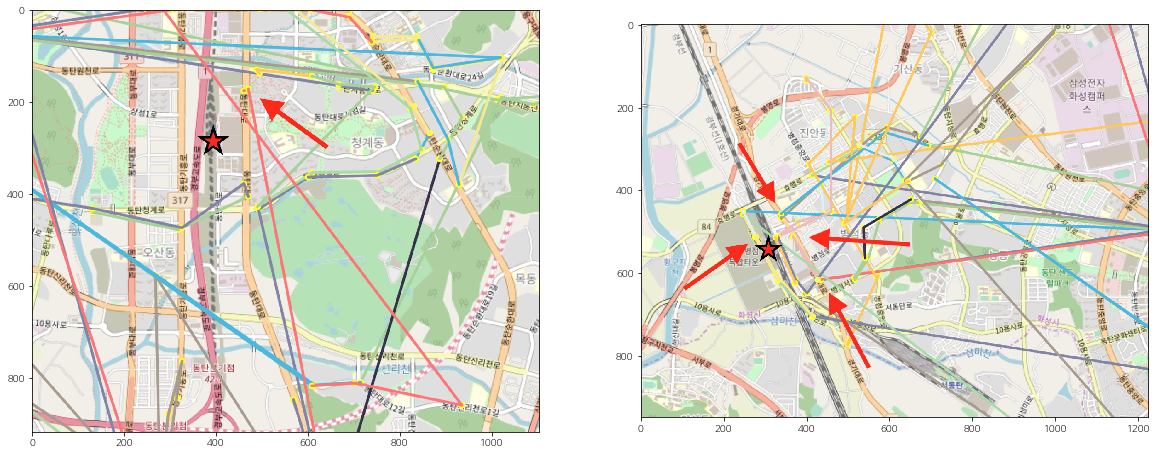

In [ ]:
d_img = mpimg.imread('dongtan.png')
b_img = mpimg.imread('bungjum.png')

fig=plt.figure(figsize=(20,20))

fig.add_subplot(1, 2, 1)
plt.imshow(d_img)

fig.add_subplot(1, 2, 2)
plt.imshow(b_img)

plt.show()

### 분석결과
위에 맵에서 볼 수있듯이 병점역에는 근접한 정류장이 많이 있으며 노선도 다양하게 있는 것을 알수있습니다. 그에 비해, 동탄역 인근 정류소는 적으며 있더라도 인근 거주지 근처에서 오는 노선이 아니라 조금 떨어진 정류소나 동탄역을 거치지 않고 병점역쪽으로 나가는 노선을 많이 볼 수가 있습니다. 사전조사 시 제일 많이 보았던 민원은 동탄동 주변 거주자들이 동탄역으로 조금 더 빠르고 편하게 역으로 갈 수 있기를 바라는거였습니다. 데이터에서도 볼 수 있듯이 아직 동탄역 인근 정류장은 많이 부족하며, 버스노선도 길고 멀리 가는 노선으로, 실제 사람들이 많이 거주하는 단지내에서 동탄역으로 바로 갈 수 있는 마을버스나 지선버스의 추가 배차가 필요한 것으로 보입니다.

---

## 3) 동탄역 vs 병점역 주변 정류장 <font color='red'>경유순서</font> 차이 분석

**동탄역과 병점역 주변 정류장의 경유순서가 어떤식으로 차이가 있는지 알아보도록 하겠습니다.**

In [ ]:
# 정류장 정보의 위치/버스번호/경유순서 정보에 대한 dataframe 생성
compare_df = pd.DataFrame(list(zip(location_list, bus_list, seq_list)), columns =['위치', 'BUS', 'SEQ']) 
compare_df

,위치,BUS,SEQ
0,경기도 화성시 동탄면,6001,43
1,경기도 화성시 동탄면,6003,57
2,경기도 화성시 병점동,17,10
3,경기도 화성시 동탄면,H6(B),50
4,경기도 화성시 병점동,35,10
...,...,...,...
56,경기도 화성시 동탄면,H6006,47
57,경기도 화성시 반월동,11-3,11
58,경기도 화성시 동탄면,38,2
59,경기도 화성시 병점동,116-2,9


**생성된 dataframe에는 4개의 distinct 위치가 존재합니다.**
- 경기도 화성시 동탄면
- 경기도 화성시 병점동
- 경기도 화성시 진안동
- 경기도 화성시 반월동

그 중 동탄면과 병점동의 위치만 추출하여 분포도를 비교해보도록 하겠습니다.

In [ ]:
dongtan = compare_df[compare_df['위치'] == '경기도 화성시 동탄면']
bungjum = compare_df[compare_df['위치'] == '경기도 화성시 병점동']

print('병점동 분포도: ')
print(bungjum.describe(), '\n')

print('동탄면 분포도: ')
print(dongtan.describe())

병점동 분포도: 
             SEQ
count  18.000000
mean   17.611111
std    13.651713
min     1.000000
25%     5.000000
50%    13.000000
75%    28.500000
max    39.000000 

동탄면 분포도: 
              SEQ
count   32.000000
mean    44.656250
std     41.518445
min      2.000000
25%     11.750000
50%     43.000000
75%     59.000000
max    152.000000


**위에 결과를 boxplot으로 시각화해보도록 하겠습니다.**

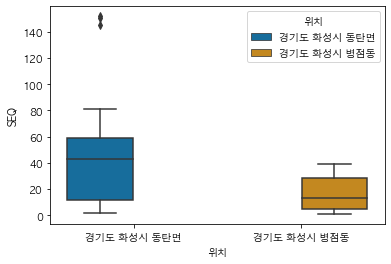

In [ ]:
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

sns.boxplot(y='SEQ', x='위치', 
            data=compare_df[(compare_df['위치'] == '경기도 화성시 동탄면') | (compare_df['위치'] == '경기도 화성시 병점동')], 
            palette="colorblind",
            hue='위치')

### 분석결과
Boxplot에서도 한 눈에 볼 수 있듯이 두 지역의 경유순서에는 차이가 있습니다. 동탄면에있는 정류장에는 대부분 정류장의순서(경유순서)가 끝쪽에 있는 반면 병점동 정류소들은 대게 앞쪽에 있는 것을 알 수 있습니다. 동탄면 정류장은 140번째가 넘는 경유순서도 있지만, 병점동 정류장은 최대 40번째의 경유순서를 갖습니다. 이를 통해 우리는 동탄역에서 출발하는 버스보다 도착하는 노선이 많다는 것을 알 수 있으며, 노선의 길이가 긴 버스들이 많이 있다는 것도 유추 할 수 있습니다. 비교적 짧은 노선을 갖는 병점동의 버스는 노선 복잡도면에서도 동탄역의 노선보다 효율적인 것을 알 수 있습니다. 시간이 오래걸리는 긴 노선에 대한 민원과 유사한 결과를 볼 수 있었으며, 기존 긴 노선들에 대해서는 검토하고 추후 새로운 버스 노선 생성시에는 동탄역 주변 출발에 대한 사항과 노선 길이를 고려하면 좋을 것 같습니다.